In [1]:
import torch
import algos
import lin_reg_algos
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def coinpress_linreg(x, y, beta, c, r, total_budget):
    """
    input:
    output:
    beta_hat = mean_est @ np.inv(cov_est)
    """
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    # TODO: private beta_norm_sqr !!
    beta_norm_sqr = beta_l2_norm(y, d) #np.linalg.norm(beta) ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget)
    cov_est = coinpress_linalg_covariance(x, d, 2, total_budget)
    beta_hat = mean_est @ np.linalg.inv(cov_est)
    return beta_hat

In [33]:
def beta_l2_norm(y, d, t=2, total_budget=0.1):
    '''need y and args={d, u, rho, t}'''
    y = torch.FloatTensor(y)

    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t

    n = len(y)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    u = 100 * d
    args = Args(n, d, u, rho, t)
    return algos.cov_est(y, args) - 1

In [4]:
def no_cov_est_priv_linreg(x, y, beta, c, r, total_budget):
    '''multiplies by (1/n)*np.linalg.inv(X.T@X) instead of inverse of covariance estimation'''
    
    n = len(x)
    d = len(x[0])

    z = []
    for i in range(n):
        z.append(x[i] * y[i])
    z = np.array(z)

    # TODO: private beta_norm_sqr !!
    beta_norm_sqr = np.linalg.norm(beta) ** 2

    mean_est = coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget)
    beta_hat = mean_est @ np.linalg.inv((1/n)*x.T@x)
    return beta_hat

In [5]:
def coinpress_linalg_covariance(x, d, t=2, total_budget=0.5):
    '''need X and args={d, u, rho, t}'''
    x = torch.FloatTensor(x)
    
    class Args:
        def __init__(self, n, d, u, rho, t):
            self.n = n
            self.d = d
            self.u = u
            self.rho = rho
            self.t = t

    n = len(x)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    # u = upper bound on largest eigenvalue on true covariance matrix
    u = 10 * np.sqrt(d)
    args = Args(n, d, u, rho, t)
    return algos.cov_est(x, args)

In [6]:
def coinpress_linreg_mean(z, c, r, d, beta_norm_sqr, total_budget=0.5):
    z = z / np.sqrt(2 * beta_norm_sqr + 1)
    rho = [(1.0 / 4.0) * total_budget, (3.0 / 4.0) * total_budget]
    return algos.multivariate_mean_iterative(z, c, r, 2, rho) * np.sqrt(2 * beta_norm_sqr + 1)

In [7]:
def losses(n_values, d, iters, total_privacy_budget, loss_func, beta_mean=0, beta_var=1.0):
    """
    returns excess loss of the private, coinpress linear regression solution
    and excess loss for the closed form solution of linear regression.

    where excess loss = E[(<x,beta_hat> - y)**2 - (<x,beta> - y)**2]
    """

    no_cov_est_priv_losses = []
    nonpriv_losses = []
    priv_losses = []
    coinpress_nonpriv_losses = []

    for n in n_values:
        no_cov_est_priv_losses_for_n = []
        nonpriv_losses_for_n = []
        priv_losses_for_n = []
        conpress_nonpriv_losses_for_n = []

        for i in range(iters):
            c = [0] * d
            r = 100 * np.sqrt(d)

            underlying_dist = generate_normal_underlying_dist(d, beta_mean, beta_var)
            x, y, _ = generate_data(n, d, underlying_dist)

            """ in each iteration, running the estimation to find beta_hat for each of the following scenarios """
            no_cov_est_priv_beta_hat = no_cov_est_priv_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            no_cov_est_priv_losses_for_n.append(loss_func(no_cov_est_priv_beta_hat, underlying_dist[0], d))
            
            priv_beta_hat = lin_reg_algos.coinpress_linreg(x, y, underlying_dist, c, r, total_privacy_budget)
            priv_losses_for_n.append(loss_func(priv_beta_hat, underlying_dist[0], d))

            nonpriv_beta_hat = linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(loss_func(nonpriv_beta_hat, underlying_dist[0], d))
            
            coinpress_nonpriv_beta_hat = lin_reg_algos.coinpress_linreg(x, y, underlying_dist, c, r, 1000)
            conpress_nonpriv_losses_for_n.append(loss_func(coinpress_nonpriv_beta_hat, underlying_dist[0], d))
            
#             coinpress_r10000_beta_hat = lin_reg_algos.coinpress_linreg(x, y, underlying_dist, c, r*100, total_privacy_budget)
#             coinpress_r10000_losses_for_n.append(loss_func())

        """ finds the mean loss for the current n for each of the following scenarios """
        no_cov_est_losses_for_n = np.array(no_cov_est_priv_losses_for_n)
        no_cov_est_priv_losses.append(np.mean(no_cov_est_priv_losses_for_n))
        
        priv_losses_for_n = np.array(priv_losses_for_n)
        priv_losses.append(np.mean(priv_losses_for_n))
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_losses.append(np.mean(nonpriv_losses_for_n))
        
        conpress_nonpriv_losses_for_n = np.array(conpress_nonpriv_losses_for_n)
        coinpress_nonpriv_losses.append(np.mean(conpress_nonpriv_losses_for_n))
        
    # TODO : add title, make y axis 0 -> 2, make sure label in top right corner / out of the way!
    plt.plot(n_values, priv_losses, 'b', label='losses using algorithm')
    plt.plot(n_values, nonpriv_losses, 'r', label='losses using closed form sol')
    plt.plot(n_values, no_cov_est_priv_losses, 'y', label='losses using algo w/o cov est.')
    plt.plot(n_values, coinpress_nonpriv_losses, 'g', label='losses using coinpress nonprivately')
    plt.legend(loc="upper right")
    axes = plt.gca()
    axes.set_ylim([0,5])

    return priv_losses, nonpriv_losses

In [8]:
def generate_normal_underlying_dist(d, beta_mean, beta_var):
    """ generates beta, <X,beta> = y"""
    underlying_dist = np.random.normal(beta_mean, beta_var, (1, d))
    return np.array(underlying_dist)

In [9]:
def generate_data(n, d, underlying_dist):
    """Creates an nxd matrix X, a 1xd underlying_dist vector, nx1 y vector, and nxd z vector (where zi=xi*yi)"""

    # generate an n x d data matrix with N(0,1) entries- feature matrix
    X = np.random.normal(0, 1.0, (n, d))
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)

    # Generate z = xy
    z = []
    for i in range(n):
        z.append(X[i] * y[i])
    z = np.array(z)

    return X, y, z

In [10]:
def linreg_closed_form_solution(x, y):
    return np.linalg.inv(x.T @ x) @ x.T @ y

In [11]:
def excess_loss(beta_hat, beta, d):
    """
    Generate 1000 d-dimensional x values and y values to test excess loss
    of our predicted beta_hat vs. underlying distribution beta
    """

    n = 1000
    x = np.random.normal(0, 1.0, (n, d))
    x = np.array(x)
    y = []

    for i in range(n):
        y.append(np.dot(beta, x[i]) + np.random.normal(0, 1.0))
    y = np.array(y)

    sum_losses = 0
    for i in range(n):
        predicted_dist = (x[i] @ beta_hat - y[i]) ** 2
        actual_dist = (x[i] @ beta - y[i]) ** 2  # if this = 1, it's essentially the same thing as n -> \inf
        loss = predicted_dist - actual_dist
        sum_losses += loss
    return sum_losses / n

In [25]:
def pop_loss(beta_hat, beta, d):
    
    # make trimmed mean? throw out 5 most extreme values?
    
    n = 1000
    
    '''generate new x values'''
    x = np.random.normal(0, 1.0, (n, d))
    x = np.array(x)
    y = []

    '''generate new y values based on underlying distribution, beta'''
    for i in range(n):
        y.append(np.dot(beta, x[i]) + np.random.normal(0, 1.0))
    y = np.array(y)
    
    '''find squared accuracy of prediction for each entry of x'''
    def dist(xi,yi):
        return np.clip((xi @ beta_hat - yi) ** 2, -5, 5)
    
    '''return MSE?'''
    losses = list(map(dist, x, y))
    # clip mean ? throw out really high values instead of trimming mean (throw out values bigger than 5)
    return np.mean(np.array(losses))

In [26]:
""" WHY IS THIS sometimes less than 1?"""

pop_loss([1,2,2],[1,2,2],3)

0.9276776055813232

In [27]:
def l1_error(beta_hat, beta, d):
    return np.linalg.norm((beta_hat-beta), ord=1)

In [28]:
def l2_error(beta_hat, beta, d):
    return np.linalg.norm(np.clip(beta_hat-beta, -5, 5))

In [29]:
def l_inf_error(beta_hat, beta, d):
    return np.linalg.norm((beta_hat-beta), ord=float('inf'))

In [30]:
l_inf_error(np.array([5,5,10]), np.array([1,1,1]), 2)

9.0

In [31]:
# n_values = list(range(100, 1500, 100))#[100,400,900,1000,1050,2000,2500,3000,3500,4000,6000]#,8000,10000]
# d = 5
# iters = 30
# total_privacy_budget=0.5

# losses(n_values, d, iters, total_privacy_budget, excess_loss)

([2.9962740458243458,
  1.9729484482135857,
  1.365939964124298,
  1.1430773802162595,
  1.070821391219549,
  1.028008994902393,
  1.0021529465525345,
  0.9924169552495542,
  0.9906183469054614,
  0.9781069210391032],
 [0.9612373014966408,
  0.954353968963527,
  0.9542213538484317,
  0.9643918478574102,
  0.9532150611467056,
  0.97335259789802,
  0.958084944684759,
  0.9583489937375601,
  0.9708684054144477,
  0.9590103742744568])

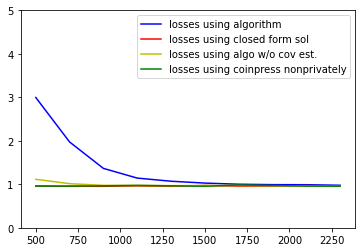

In [34]:
n_values = range(500,2500,200)#[500,1000,1500,2000,4000]#,6000,8000,10000]
d = 5
iters = 30
total_privacy_budget=0.5

losses(n_values, d, iters, total_privacy_budget, pop_loss)

- dist between X.T@X and identity (Frobenius norm)
- dist between coinpress_cov and identity (also F norm)

In [20]:
d = 5
n = 2000

X = np.random.normal(0, 1.0, (n, d))
X = np.array(X)

errors = []
cov_errors = []
for i in range(100):
    errors.append(np.linalg.norm(((1/n)*X.T@X - np.eye(d)), 'fro'))
    cov_errors.append(np.linalg.norm((coinpress_linalg_covariance(X, d, t=2, total_budget=0.5) - (1/n)*X.T@X), 'fro'))
    
print(np.mean(np.array(errors)))
print(np.mean(np.array(cov_errors)))

0.11137338082960183
0.1626050815322836


PLOTS
- pop_loss, l2_error
- clip values before taking average? or find median
    - general principle when looking at large avg errors: are all errors abt the same or is there something skewing avg
    
OTHER
- 'hyperparameter tuning' figure out privacy split
- norm of beta